todo-list
=========
<li>Migrate static->stream(if possible)</li>
<li>Find new efficient way to do pattern detection/anomaly detection</li>
<li>Email alert config (now sent to yanisa.sunthornyotin@cern.ch)</li>

In [ ]:
spark.streams.active

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
userSchema = StructType() \
        .add("window",StructType()\
             .add("start",TimestampType())\
             .add("end",TimestampType()))\
        .add("system", StringType())\
        .add("api", StringType())\
        .add("user", StringType())\
        .add("count_req", LongType())

In [4]:
raw_data = spark\
.readStream.format("parquet")\
.schema(userSchema)\
.load("/cms/users/carizapo/ming/data_cmsweb_logs");
raw_data.printSchema()

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- system: string (nullable = true)
 |-- api: string (nullable = true)
 |-- user: string (nullable = true)
 |-- count_req: long (nullable = true)



In [3]:
# raw_data_flow.lastProgress

In [ ]:
# raw_data_flow = raw_data.writeStream.queryName("req").outputMode("Append").format("memory").start()

In [ ]:
# alerts = spark.sql("select * from req")
# alerts.show()

In [5]:
temp_data = spark\
.read.format("parquet")\
.load("/cms/users/carizapo/ming/data_cmsweb_logs");
temp_data.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- system: string (nullable = true)
 |-- api: string (nullable = true)
 |-- user: string (nullable = true)
 |-- count_req: long (nullable = false)



In [6]:
temp_data=temp_data.sample(False, 0.1, seed=0).limit(2000)

Calculate % Difference according to the mean of the amounth of email within 1 day
-----------

In [7]:
from pyspark.sql import Window
obs_interval=window("window.start", "1 minute")
mean_interval=window("window.start", "1 day")

columns_drop=['diff_user','diff_api','diff_sys','diff_req']

wo_sys = Window.partitionBy('system',obs_interval)
wo_user = Window.partitionBy('user',obs_interval)
wo_api = Window.partitionBy('api',obs_interval)
wo_req = Window.partitionBy('system','user','api',obs_interval)


wm_sys = Window.partitionBy('system',mean_interval)
wm_user = Window.partitionBy('user',mean_interval)
wm_api = Window.partitionBy('api',mean_interval)
wm_req = Window.partitionBy('system','user','api',mean_interval)

# .orderBy(col("window.start").cast('long')).rangeBetween(-days(7), 0)

freq_analyze_df=temp_data\
.filter("user!='null' and user!='-'")\
.select('*', sum('count_req').over(wo_req).alias('req_load'))\
.select('*', count('system').over(wo_sys).alias('system_load'))\
.select('*', count('api').over(wo_api).alias('api_load'))\
.select('*', count('user').over(wo_user).alias('user_load'))
freq_analyze_df=freq_analyze_df\
.select('*', avg('req_load').over(wm_req).alias('avg_req'))\
.select('*', ((col('req_load') - first('avg_req').over(wo_req))).alias('diff_req'))\
.select('*', ((col('diff_req')/first('avg_req').over(wo_req))).alias('%diff_req'))\
.select('*', avg('system_load').over(wm_sys).alias('avg_sys'))\
.select('*', ((col('system_load') - first('avg_sys').over(wo_sys))).alias('diff_sys'))\
.select('*', ((col('diff_sys')/first('avg_sys').over(wo_sys))).alias('%diff_sys'))\
.select('*', avg('api_load').over(wm_api).alias('avg_api'))\
.select('*', ((col('api_load') - first('avg_api').over(wo_api))).alias('diff_api'))\
.select('*', ((col('diff_api')/first('avg_api').over(wo_api))).alias('%diff_api'))\
.select('*', avg('user_load').over(wm_user).alias('avg_user'))\
.select('*', ((col('user_load') - first('avg_user').over(wo_user))).alias('diff_user'))\
.select('*', ((col('diff_user')/first('avg_user').over(wo_user))).alias('%diff_user'))\
.drop(*columns_drop)
#Todos:Transform/Refactor to UDF
# .select('*', when((abs(col('%diff'))>3), 1).otherwise(0).alias('label'))

# freq_analyze_df.filter("system=='crabserver'").show()

In [8]:
raw_data=raw_data.join(freq_analyze_df, ["system","window","api","user","count_req"], "inner")
raw_data.printSchema()

root
 |-- system: string (nullable = true)
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- api: string (nullable = true)
 |-- user: string (nullable = true)
 |-- count_req: long (nullable = true)
 |-- req_load: long (nullable = true)
 |-- system_load: long (nullable = false)
 |-- api_load: long (nullable = false)
 |-- user_load: long (nullable = false)
 |-- avg_req: double (nullable = true)
 |-- %diff_req: double (nullable = true)
 |-- avg_sys: double (nullable = true)
 |-- %diff_sys: double (nullable = true)
 |-- avg_api: double (nullable = true)
 |-- %diff_api: double (nullable = true)
 |-- avg_user: double (nullable = true)
 |-- %diff_user: double (nullable = true)



In [9]:
full_diff_flow = raw_data.writeStream.queryName("MLdf").outputMode("Append").format("memory").start()

In [10]:
full_difference_hdfs=raw_data.writeStream\
.outputMode("append")\
.format("parquet")\
 .option("path", "/cms/users/carizapo/ming/fullDiff_cmsweb_logs") \
 .option("checkpointLocation", "/cms/users/carizapo/ming/checkpoint_fullDiff_cmsweb_logs") \
 .outputMode("append") \
 .start()

In [ ]:
full_diff_flow.stop()
full_difference_hdfs.stop()
# raw_data_flow.stop()
# filter_alert_data_flow.stop()
# difference_hdfs_flow.stop()

In [ ]:
full_diff_flow.isActive

In [11]:
spark.streams.active

In [15]:
full_diff_flow.lastProgress
# # full_difference_hdfs.lastProgress
# raw_data_flow.lastProgress
# full_diff_flow.processAllAvailable()

{'id': '18b8447a-f06b-4162-a26f-7e72cd3c47b6',
 'runId': '5eeba935-c5c3-49f7-a6d7-1d624ef9e467',
 'name': 'MLdf',
 'timestamp': '2019-07-18T11:48:53.352Z',
 'batchId': 1,
 'numInputRows': 3582,
 'inputRowsPerSecond': 18.293710579402976,
 'processedRowsPerSecond': 64.49754217908782,
 'durationMs': {'addBatch': 42990,
  'getBatch': 3878,
  'getOffset': 3894,
  'queryPlanning': 4324,
  'triggerExecution': 55537,
  'walCommit': 229},
 'stateOperators': [],
 'sources': [{'description': 'FileStreamSource[hdfs://analytix/cms/users/carizapo/ming/data_cmsweb_logs]',
   'startOffset': {'logOffset': 0},
   'endOffset': {'logOffset': 1},
   'numInputRows': 3582,
   'inputRowsPerSecond': 18.293710579402976,
   'processedRowsPerSecond': 64.49754217908782}],
 'sink': {'description': 'MemorySink'}}

In [16]:
alerts = spark.sql("select * from MLdf")
# alerts.select(["system","user"]).distinct().show(10,False)

In [ ]:
# alerts=alerts.filter("user=='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=yousen/CN=Yousen Zhang' or user=='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=akormu/CN=Anna Kaarina Kormu' or user=='/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=leac/CN=Lea Michaela Caminada'")

In [17]:
raw_data_init = alerts.withColumn('date',col("window.start")).drop(col("window"))

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator


sys_indexer = StringIndexer(inputCol="system", outputCol="system_hash")
user_indexer = StringIndexer(inputCol="user", outputCol="user_hash")
api_indexer = StringIndexer(inputCol="api", outputCol="api_hash")
inputs = [sys_indexer.getOutputCol(), user_indexer.getOutputCol(),api_indexer.getOutputCol()]
encoder = OneHotEncoderEstimator(inputCols=inputs, outputCols=["system_vec","user_vec","api_vec"])

# encoder = OneHotEncoderEstimator(
#     inputCols=["system_hash","user_hash","api_hash"],  
#     outputCols=["req_vector"]
# )

pipeline = Pipeline(stages=[sys_indexer,user_indexer,api_indexer, encoder])
result=pipeline.fit(raw_data_init).transform(raw_data_init)

# word2vec = Word2Vec(inputCol = 'user', outputCol = 'user_hash')
# model = word2vec.fit(raw_data_init)
# result = model.transform(raw_data_init)
# result.select("user","system","api","system_hash","user_hash","api_hash","system_vec","user_vec","api_vec").show(1)

In [ ]:
result.printSchema()

In [19]:
%run StoreItemDemand/custom_transformers.ipynb

In [20]:
train_data, test_data = result.randomSplit([0.8,0.2], seed=1234)

In [21]:
df_train = train_data.withColumn('set', lit(0))
df_train = df_train.withColumn('id', lit(-1))
df_test = test_data.withColumn('set', lit(1))

joined = df_test.union(df_train.select(*df_test.columns))

train_data = joined.filter('set == 0')
test_data = joined.filter('set == 1')

In [22]:
train, validation = train_data.randomSplit([0.8,0.2], seed=1234)

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler,StandardScaler
# Feature extraction
dc = DateConverter(inputCol='date', outputCol='dateFormated')
hrex = HourExtractor(inputCol='date')
minex = MinExtractor(inputCol='date')
dex = DayExtractor(inputCol='dateFormated')
mex = MonthExtractor(inputCol='dateFormated')
yex = YearExtractor(inputCol='dateFormated')
wdex = WeekDayExtractor(inputCol='dateFormated')
wex = WeekendExtractor()
mbex = MonthBeginExtractor()
meex = MonthEndExtractor()
# Data process
va = VectorAssembler(inputCols=["system_vec","user_vec","api_vec",'count_req','%diff_req','%diff_sys','%diff_api','%diff_user'\
                                 ,'weekday', 'weekend', 'monthbegin', 'monthend','hour','minute', 'day', 'month', 'year'], outputCol="features")
# scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
# scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")

# Serialize data
# sm = SerieMaker(inputCol='scaledFeatures', dateCol='date', idCol=['systemID'], serieSize=30)

pipeline = Pipeline(stages=[dc,hrex,minex, dex, mex,wdex,wex,mbex,meex, yex, va])

In [24]:
pipiline_model = pipeline.fit(train)

In [25]:
train_transformed = pipiline_model.transform(train)
validation_transformed = pipiline_model.transform(validation)
test_transformed = pipiline_model.transform(test_data)

In [ ]:
# arr=train_transformed.select("raw_features","features").show(1,False)

In [26]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(train_transformed.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(train_transformed) # requires Spark 2.0 or later


Text(0,0.5,'cost')

Text(0,0.5,'cost')

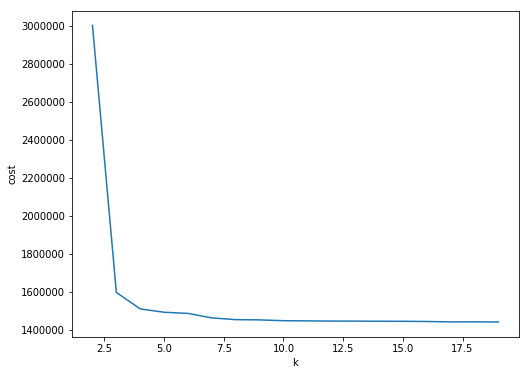

In [27]:

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [42]:
from numpy import array
from math import sqrt

kmeans = KMeans(k=7, seed=1)  # 2 clusters here
model = kmeans.fit(train_transformed.select('features'))

In [43]:
transformed = model.transform(train_transformed).drop('features')
# transformed.select("system").distinct().show(5)

In [58]:
transform_df=transformed.toPandas()
print(transform_df['system'].unique())

['couchdb' 'crabserver' 'das' 'dbs' 'dqm' 'phedex' 'reqmgr2'
 'wmstatsserver' 'crabcache' 'scheddmon' 'sitedb']


In [45]:
transform_df.shape

(1313, 35)

In [95]:
import pandas as pd
filter_data=transform_df[(transform_df.system =='couchdb')]
filter_data.head(5)

,system,api,user,count_req,req_load,system_load,api_load,user_load,avg_req,%diff_req,...,hour,minute,day,month,weekday,weekend,monthbegin,monthend,year,prediction
0,couchdb,_revs_diff,/DC=ch/DC=cern/OU=computers/CN=wmagent/vocms02...,89,89,1,1,1,93.666667,-0.049822,...,12,58,17,7,4,0,0,0,2019,0
1,couchdb,_revs_diff,/DC=ch/DC=cern/OU=computers/CN=wmagent/vocms02...,153,153,1,1,1,93.666667,0.633452,...,11,2,17,7,4,0,0,0,2019,4
2,couchdb,agentInfo,/DC=ch/DC=cern/OU=computers/CN=dmwm/cmsweb.cer...,1,1,125,1,97,1.000000,0.000000,...,15,0,17,7,4,0,0,0,2019,0
3,couchdb,asikdar_RVCMSSW_11_0_0_pre3QCD_Pt_80_120_13__F...,/DC=ch/DC=cern/OU=computers/CN=dmwm/cmsweb.cer...,1,1,1,1,1,1.000000,0.000000,...,13,14,17,7,4,0,0,0,2019,0
4,couchdb,chayanit_RVCMSSW_10_6_1_patch1QCDFlat_13UP21_P...,/DC=ch/DC=cern/OU=computers/CN=dmwm/cmsweb.cer...,1,1,3,1,3,1.000000,0.000000,...,12,35,17,7,4,0,0,0,2019,0


In [96]:
filter_data.set_index('date', inplace=True)

In [97]:
prep=filter_data[['%diff_req','%diff_sys','%diff_api','%diff_user']]
label=filter_data[['prediction']]

In [98]:
prep.head(10)

,%diff_req,%diff_sys,%diff_api,%diff_user
date,,,,
2019-07-17 12:58:00,-0.049822,-0.966503,0.0,-0.849779
2019-07-17 11:02:00,0.633452,-0.966503,0.0,-0.849779
2019-07-17 15:00:00,0.000000,3.187137,0.0,3.110202
2019-07-17 13:14:00,0.000000,-0.966503,0.0,-0.957627
2019-07-17 12:35:00,0.000000,-0.899509,0.0,-0.872880
2019-07-17 15:01:00,0.000000,2.651184,0.0,2.686470
2019-07-17 11:03:00,0.000000,-0.933006,0.0,-0.915254
2019-07-17 15:00:00,0.000000,3.187137,0.0,3.110202
2019-07-17 15:01:00,0.000000,2.651184,0.0,2.686470


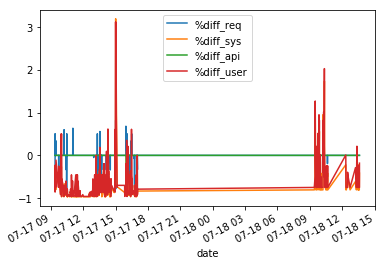

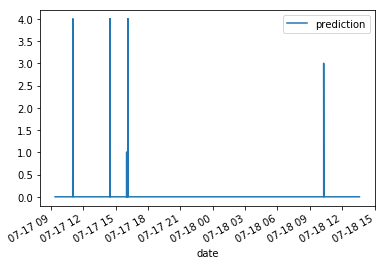

In [99]:
%matplotlib inline

# prep_fix=prep.loc['2019-07-1 22:00:00':'2019-07-2 21:00:00']
prep.plot()
label.plot()